<a href="https://colab.research.google.com/github/YichengShen/segment-anything/blob/main/testing/SamAutomaticMaskGenerator%E6%B5%8B%E8%AF%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SamAutomaticMaskGenerator测试

## 环境设置

*   要求 `python>=3.8， pytorch>=1.7， torchvision>=0.8`
*   需要下载模型checkpoint(大约2.4G)



In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

    !mkdir images

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0jnykb6t
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0jnykb6t
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=e5f6c4f795c16227f80eb0e72b6ad6d43b79f0fa16d08c91cb7862eaf2272025
  Stored in directory: /tmp/pip-ephem-wheel-cache-v6f3eryc/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segm

## 包、辅助函数

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import urllib.request

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## 下载和展示图片

In [5]:
# 下载图片
urls = ["https://www.bc.edu/content/bc-web/admission/apply/admission-offices/_jcr_content/par/bc_padded_section/par/responsive_columns_13838541/col2/school_video/image.img.jpg/1627507259477.jpg",
        "https://image.cnbcfm.com/api/v1/image/106947859-GettyImages-167503543.jpg?v=1632760991",
        "https://www.verywellhealth.com/thmb/DLpqCc8I2RoV_glIQN-dgxii4sk=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/cml-under-microscope-5b85803346e0fb005093fb84.jpg"]

for i, url in enumerate(urls):
    urllib.request.urlretrieve(url, f"/content/images/image{i+1}.jpg")

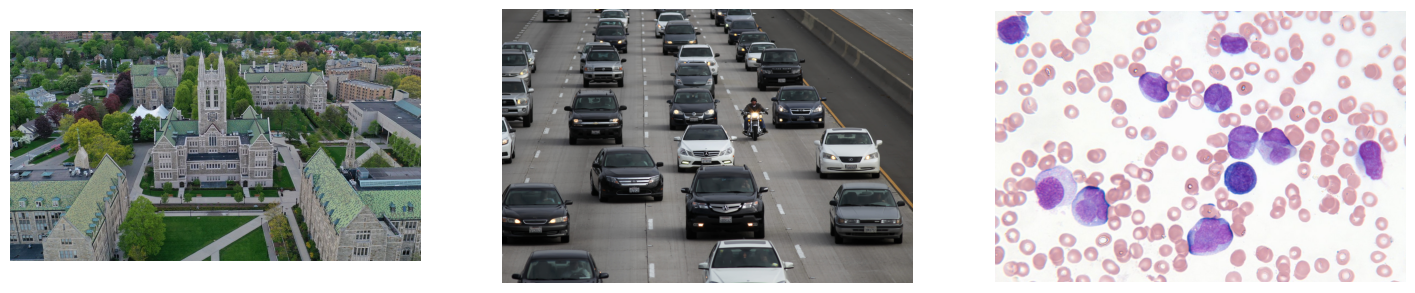

In [6]:
# 预览图片
image1 = cv2.imread('images/image1.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.imread('images/image2.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3 = cv2.imread('images/image3.jpg')
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(18,6))

plt.subplot(1, 3, 1) 
plt.imshow(image1)
plt.axis('off')

plt.subplot(1, 3, 2) 
plt.imshow(image2)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image3)
plt.axis('off')

plt.show()

## 测试SamAutomaticMaskGenerator在图片上的效果

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

### 图片1: 建筑群

SamAutomaticMaskGenerator有很多参数。参数的含义见下方链接：

https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py#:~:text=ViT%2DH%20backbone.-,Arguments%3A,memory.,-%22%22%22



In [8]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, 
)

masks = mask_generator.generate(image1)
print("mask的数量：", len(masks))

mask的数量： 386


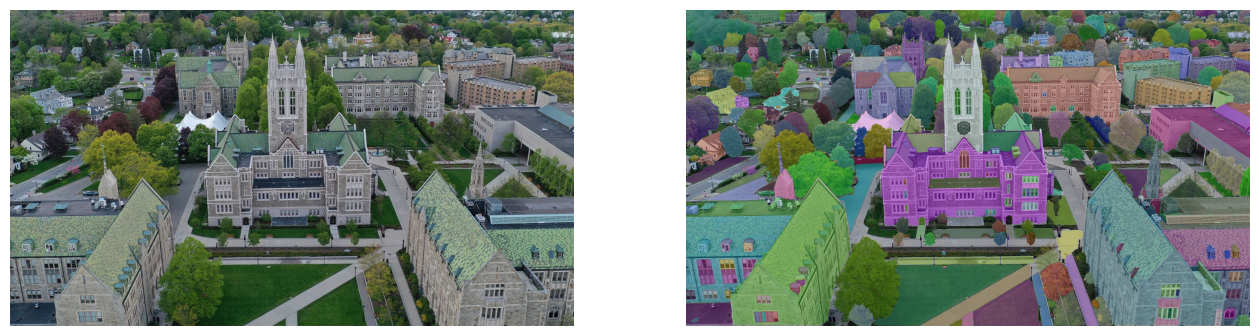

In [9]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1) 
plt.imshow(image1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image1)
show_anns(masks)
plt.axis('off')

plt.show()

### 图片2: 车辆

mask的数量： 207


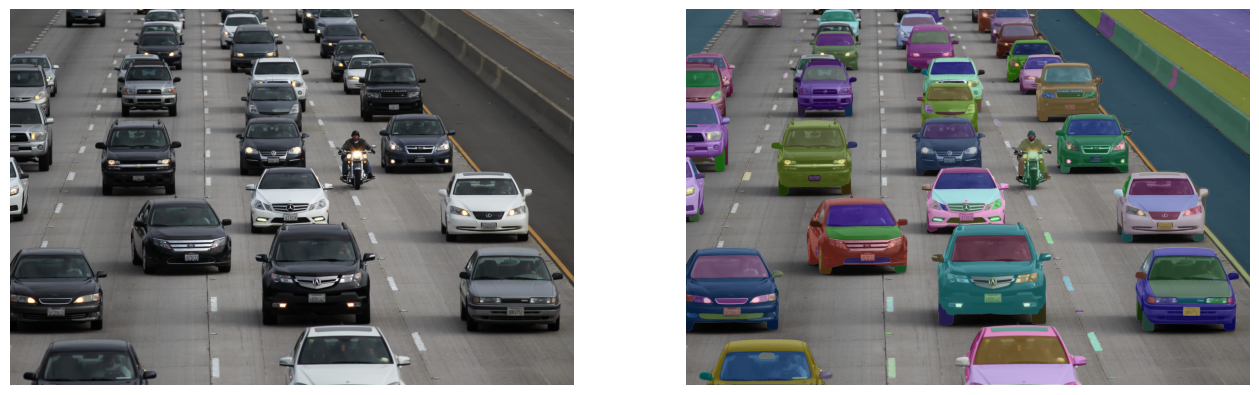

In [10]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.92,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, 
)

masks = mask_generator.generate(image2)
print("mask的数量：", len(masks))

plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1) 
plt.imshow(image2)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2)
show_anns(masks)
plt.axis('off')

plt.show()

### 图片3：细胞

mask的数量： 187


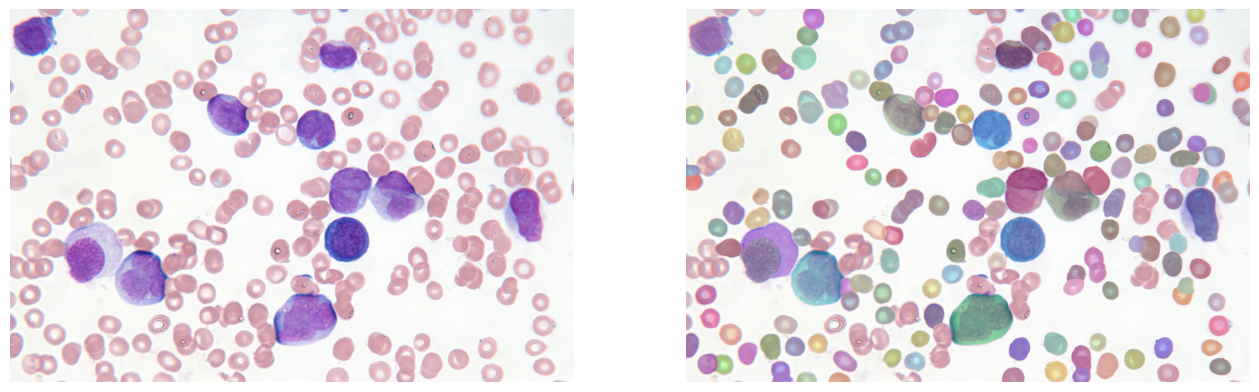

In [12]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.98,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, 
)

masks = mask_generator.generate(image3)
print("mask的数量：", len(masks))

plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1) 
plt.imshow(image3)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image3)
show_anns(masks)
plt.axis('off')

plt.show()